In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(19753, 28)
(19753, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
## Entries where FL is swinging
idxs = np.where(X_motion[:, 21] == 1)[0]
X_motion_FL_swinging = X_motion[idxs]
Y_motion_FL_swinging = Y_motion[idxs]

## Predict FL foot -> x

In [8]:
X_motion_FL_swinging.shape

(9881, 28)

In [9]:
Y_motion_FL_swinging.shape

(9881, 4)

In [10]:
X_motion_FL_swinging[0, :]

array([ 1.00000001e-01,  0.00000000e+00,  0.00000000e+00, -5.57024908e-02,
       -5.40215102e-02, -1.11360393e-02, -2.17167590e-03,  8.77903505e-03,
        1.45651991e-02, -7.12314382e-02, -3.92716837e-01,  5.50087365e-05,
       -4.12321678e-01,  9.00164092e-03,  1.81498391e-04,  3.90894338e-01,
       -3.59212136e-02,  6.71357023e-05,  4.65485384e-02,  4.03726371e-01,
       -3.03642830e-04,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  1.00000001e-01,  0.00000000e+00,  0.00000000e+00])

In [11]:
Y_motion_FL_swinging[0, :]

array([ 0.03980751, -0.00123594,  0.0396313 , -0.00104227])

### Linear Regression

In [12]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # prev velocity command
               X_motion_FL_swinging[:, -3:], # commanded velocity command
               X_motion_FL_swinging[:, 3:9], # velocity state
               X_motion_FL_swinging[:, 9:11], # FL (x,y) position
               X_motion_FL_swinging[:, 12:14], # FR (x,y) position
               X_motion_FL_swinging[:, 15:17], # RL (x,y) position
               X_motion_FL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)
    
# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.944887139802977
RMSE:  0.01771777024479253
The lowest error is:  9.052018710986598e-08
The highest error is:  0.25424761275838853
The avg. error is:  0.010862905067517567


In [13]:
model_fl_relative_support_x.coef_

array([[-0.00931334,  0.02553464, -0.03621113,  0.23010621,  0.00954107,
        -0.01059536,  0.05799315, -0.08039285, -0.06127811,  0.20231607,
         0.24681589, -0.02351633,  0.07620587, -0.02472352, -0.4070535 ,
         0.61000529, -0.50346683,  0.52665163, -0.01337266,  0.09874432]])

In [14]:
model_fl_relative_support_x.intercept_

array([0.01011716])

Text(0, 0.5, 'Predictions')

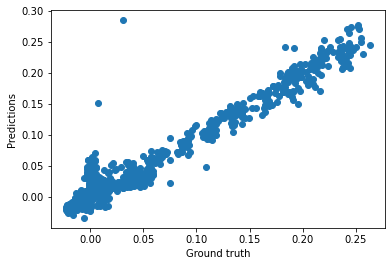

In [15]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [16]:
#%store model_fl_relative_support_x

In [17]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [18]:
# Save model
#joblib.dump(model_fl_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_x.sav")

### Predict FL foot -> y

In [19]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # prev velocity command
               X_motion_FL_swinging[:, -3:], # commanded velocity command
               X_motion_FL_swinging[:, 3:9], # velocity state
               X_motion_FL_swinging[:, 9:11], # FL (x,y) position
               X_motion_FL_swinging[:, 12:14], # FR (x,y) position
               X_motion_FL_swinging[:, 15:17], # RL (x,y) position
               X_motion_FL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8689189976215371
RMSE:  0.016164191985543603
The lowest error is:  8.110008424343229e-06
The highest error is:  0.2113290219502256
The avg. error is:  0.009482804292376835


In [20]:
model_fl_relative_support_y.coef_

array([[ 0.02937976, -0.00185482,  0.01637285,  0.00837371,  0.2364913 ,
         0.02549281,  0.07409262,  0.02166438, -0.08341625, -0.2316023 ,
        -0.03638945,  0.05555931, -0.07474167,  0.1506397 , -0.12833734,
         0.02268914, -0.12533426,  0.09399921, -0.01578136,  0.14609526]])

In [21]:
model_fl_relative_support_y.intercept_

array([-0.00183315])

Text(0, 0.5, 'Predictions')

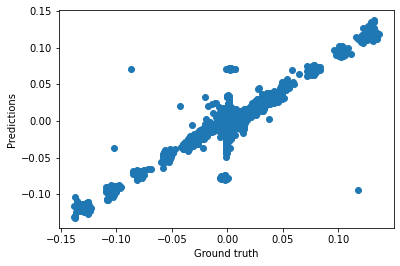

In [22]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [23]:
#%store model_fl_relative_support_y

In [24]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [25]:
# Save model
#joblib.dump(model_fl_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_y.sav")